# Swish vs HardSwish — Aynı Model, Aynı Eğitim, Yan Yana Karşılaştırma 📊

Bu notebook:
- **Aynı mimari** (sadece aktivasyon farklı)
- **Aynı dataset/augment**
- **Aynı optimizer/LR/scheduler**
- **Aynı seed**

ile **Swish** ve **HardSwish** modellerini yan yana eğitir ve sonuçları karşılaştırır.

> Dosya yapın:
> - `HardSigmoid/models/swish.py`
> - `HardSigmoid/models/hardswish.py`
> Notebook: `HardSigmoid/to_compare/` içinde çalışabilir.


## 1) Path Fix + Imports

In [15]:
import os, sys, random, time
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

ROOT = r"C:\Users\hdgn5\OneDrive\Belgeler\GitHub\pytorch-cnn-architecture-library\Torch_CNN\activation_functions\Egde\HardSwish"
if ROOT not in sys.path:
    sys.path.insert(0, ROOT)

# Modeller
from models.swish import build_model as build_swish_model
from models.hardswish import build_model as build_hardswish_model

print("Imports OK ✅")


Imports OK ✅


## 2) Device + AMP (Mixed Precision)

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
use_amp = True and (device == "cuda")
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

print("device:", device, "| amp:", use_amp)

device: cuda | amp: True


C:\Users\hdgn5\AppData\Local\Temp\ipykernel_7080\2082159042.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


## 3) Seed / Reproducibility

In [17]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False

seed = 42
seed_everything(seed)


## 4) Hyperparameters

In [18]:
epochs = 15
batch_size = 128
lr = 3e-4
weight_decay = 5e-4
num_workers = 4
data_root = os.path.join(ROOT, "data")  


## 5) Dataset & DataLoaders (CIFAR-10)

In [19]:
mean = (0.4914, 0.4822, 0.4465)
std  = (0.2023, 0.1994, 0.2010)

train_tf = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_set = datasets.CIFAR10(root=data_root, train=True, download=True, transform=train_tf)
test_set  = datasets.CIFAR10(root=data_root, train=False, download=True, transform=test_tf)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=True, drop_last=True)

test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False,
                         num_workers=num_workers, pin_memory=True)

num_classes = 10

Files already downloaded and verified
Files already downloaded and verified


## 6) Build Models (Same architecture, different activation)

In [20]:
model_swish = build_swish_model(num_classes=num_classes).to(device)
model_hswish = build_hardswish_model(num_classes=num_classes).to(device)

print("swish params:", sum(p.numel() for p in model_swish.parameters()))
print("hardswish params:", sum(p.numel() for p in model_hswish.parameters()))


swish params: 1340746
hardswish params: 1340746


## 7) Loss / Optimizers / Schedulers

In [21]:
criterion = nn.CrossEntropyLoss()

opt_swish = torch.optim.AdamW(model_swish.parameters(), lr=lr, weight_decay=weight_decay)
opt_hswish = torch.optim.AdamW(model_hswish.parameters(), lr=lr, weight_decay=weight_decay)

sched_swish = torch.optim.lr_scheduler.CosineAnnealingLR(opt_swish, T_max=epochs)
sched_hswish = torch.optim.lr_scheduler.CosineAnnealingLR(opt_hswish, T_max=epochs)


## 8) Train / Eval Functions

In [22]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        logits = model(x)
        loss = criterion(logits, y)
        total_loss += loss.item() * x.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)
    return total_loss / total, correct / total


def train_one_epoch(model, optimizer, loader):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=use_amp):
            logits = model(x)
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * x.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)

    return total_loss / total, correct / total


## 9) Training Loop (Epoch-by-epoch side-by-side logging)

In [23]:
history = {
    "Swish": {"train_loss": [], "test_loss": [], "acc": []},
    "HardSwish": {"train_loss": [], "test_loss": [], "acc": []},
}

for ep in range(1, epochs + 1):
    t0 = time.time()

    tr_l_s, tr_a_s = train_one_epoch(model_swish, opt_swish, train_loader)
    te_l_s, te_a_s = evaluate(model_swish, test_loader)

    tr_l_h, tr_a_h = train_one_epoch(model_hswish, opt_hswish, train_loader)
    te_l_h, te_a_h = evaluate(model_hswish, test_loader)

    sched_swish.step()
    sched_hswish.step()

    history["Swish"]["train_loss"].append(tr_l_s)
    history["Swish"]["test_loss"].append(te_l_s)
    history["Swish"]["acc"].append(te_a_s)

    history["HardSwish"]["train_loss"].append(tr_l_h)
    history["HardSwish"]["test_loss"].append(te_l_h)
    history["HardSwish"]["acc"].append(te_a_h)

    dt = time.time() - t0

    print(
        f"Epoch {ep:02d}/{epochs} | "
        f"Swish: train_loss={tr_l_s:.4f} test_loss={te_l_s:.4f} acc={te_a_s:.4f} | "
        f"HardSwish: train_loss={tr_l_h:.4f} test_loss={te_l_h:.4f} acc={te_a_h:.4f} | "
        f"time={dt:.1f}s"
    )


C:\Users\hdgn5\AppData\Local\Temp\ipykernel_7080\3716211461.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch 01/15 | Swish: train_loss=1.7953 test_loss=1.4519 acc=0.4686 | HardSwish: train_loss=1.8492 test_loss=1.5251 acc=0.4363 | time=110.8s
Epoch 02/15 | Swish: train_loss=1.4922 test_loss=1.3357 acc=0.5119 | HardSwish: train_loss=1.5289 test_loss=1.3401 acc=0.5045 | time=108.7s
Epoch 03/15 | Swish: train_loss=1.3823 test_loss=1.2559 acc=0.5413 | HardSwish: train_loss=1.4007 test_loss=1.2543 acc=0.5385 | time=112.6s
Epoch 04/15 | Swish: train_loss=1.2863 test_loss=1.1604 acc=0.5789 | HardSwish: train_loss=1.3203 test_loss=1.1832 acc=0.5666 | time=114.8s
Epoch 05/15 | Swish: train_loss=1.2098 test_loss=1.0947 acc=0.6112 | HardSwish: train_loss=1.2397 test_loss=1.1246 acc=0.5933 | time=115.9s
Epoch 06/15 | Swish: train_loss=1.1449 test_loss=1.0327 acc=0.6284 | HardSwish: train_loss=1.1781 test_loss=1.0745 acc=0.6168 | time=98.8s
Epoch 07/15 | Swish: train_loss=1.0951 test_loss=0.9872 acc=0.6535 | HardSwish: train_loss=1.1225 test_loss=1.0337 acc=0.6318 | time=96.8s
Epoch 08/15 | Swish: t

## 10) Summary Table (Final + Peak)

In [24]:
import pandas as pd

def summarize(key):
    acc = np.array(history[key]["acc"])
    tl  = np.array(history[key]["test_loss"])
    return {
        "final_acc": float(acc[-1]),
        "peak_acc": float(acc.max()),
        "peak_epoch": int(acc.argmax() + 1),
        "final_test_loss": float(tl[-1]),
        "min_test_loss": float(tl.min()),
        "min_loss_epoch": int(tl.argmin() + 1),
    }

df = pd.DataFrame([summarize("Swish"), summarize("HardSwish")], index=["Swish", "HardSwish"])
df

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000028DDF0E1090>
Traceback (most recent call last):
  File "c:\Users\hdgn5\.conda\envs\torch_gpu\lib\site-packages\torch\utils\data\dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "c:\Users\hdgn5\.conda\envs\torch_gpu\lib\site-packages\torch\utils\data\dataloader.py", line 1562, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


,final_acc,peak_acc,peak_epoch,final_test_loss,min_test_loss,min_loss_epoch
Swish,0.7025,0.7025,15,0.859580,0.859580,15
HardSwish,0.6824,0.6824,15,0.893328,0.893328,15


## 11) Plots (Accuracy / Loss)

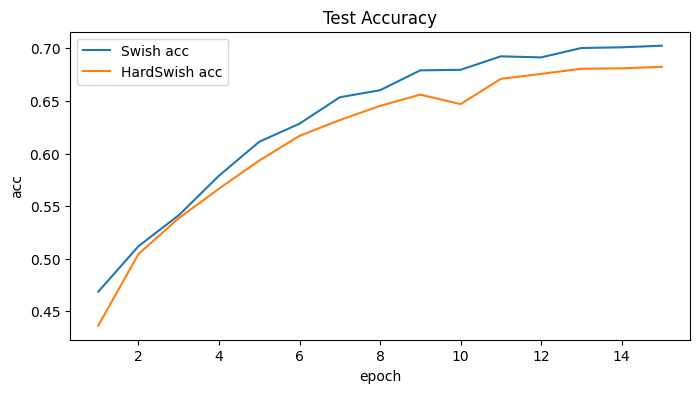

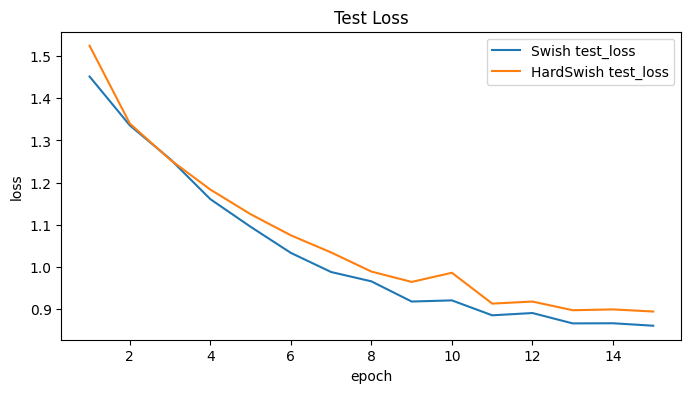

In [25]:
import matplotlib.pyplot as plt

ep_axis = np.arange(1, epochs + 1)

plt.figure(figsize=(8,4))
plt.plot(ep_axis, history["Swish"]["acc"], label="Swish acc")
plt.plot(ep_axis, history["HardSwish"]["acc"], label="HardSwish acc")
plt.xlabel("epoch"); plt.ylabel("acc"); plt.title("Test Accuracy")
plt.legend(); plt.show()

plt.figure(figsize=(8,4))
plt.plot(ep_axis, history["Swish"]["test_loss"], label="Swish test_loss")
plt.plot(ep_axis, history["HardSwish"]["test_loss"], label="HardSwish test_loss")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Test Loss")
plt.legend(); plt.show()

## 📊 Swish vs HardSwish (15 Epoch Karşılaştırma)

| Model | Final Test Acc (Ep15) | Final Test Loss (Ep15) | Final Train Loss (Ep15) | Peak Acc (Epoch) | Genel Eğilim |
|------|------------------------|-------------------------|--------------------------|------------------|--------------|
| **Swish** | **0.7025** | **0.8596** | **0.8946** | **0.7025 (Ep15)** | Daha iyi genelleme, daha düşük test loss |
| **HardSwish** | 0.6824 | 0.8933 | 0.9317 | 0.6824 (Ep15) | Daha düşük doğruluk, test loss daha yüksek |

---

## 🧠 Yorum (Net)

- Bu koşullarda **Swish açıkça daha iyi**:  
  **+0.0201 (~+2.0 puan) test accuracy** ve **daha düşük test loss** veriyor.
- HardSwish’in olayı çoğunlukla **mobil/edge inference** (latency) tarafı; yani “hız için accuracy’den biraz feragat” yaklaşımı.  
  Senin deneyinde bu feragat net görünüyor.
- İki model de epoch ilerledikçe toparlıyor ama **Swish her epoch’ta genelde önde** ve finalde farkı kapatmıyor, **fark büyüyerek kapanıyor**.

✅ **Karar:** Accuracy öncelikliyse **Swish**, edge/deploy öncelikliyse (latency önemliyse) **HardSwish** değerlendirilebilir.
